In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tabulate
from itertools import chain
from scipy import stats
from autorank import autorank,create_report,plot_stats
pd.set_option("chained_assignment", None)
pd.set_option("display.max_rows", 5000)
pd.set_option("display.max_columns", 5000)
pd.set_option("display.width", 10000)

def load_priorband_data():
    df = pd.read_parquet("data_for_anton.parquet")
    df=df.reset_index()
    df_collection=[]
    for seed_nr in range(50):
        partial_df=df[["benchmark","prior","algorithm","used_fidelity"]]
        partial_df["value"]=df[f"seed-{seed_nr}"]
        partial_df["seed"]=seed_nr
        df_collection.append(partial_df)
        print(f"Seed {seed_nr+1}/50", end="\r", flush=True)
    return pd.concat(df_collection,ignore_index=True)

df=load_priorband_data()

In [3]:
algo_dict={"rs_hb_pb":["random_search","hyperband","pb_mutation_dynamic_geometric-default-at-target"]}
#algo_dict["fig7"]=["random_search_prior","bo","bohb","priorband_bo"]
prior_dict={"good+bad":["at25","bad"]}
benchmarks=["jahs_cifar10","jahs_colorectal_histology","jahs_fashion_mnist","lcbench-126026","lcbench-167190","lcbench-168330","lcbench-168910","lcbench-189906","cifar100_wideresnet_2048","imagenet_resnet_512","lm1b_transformer_2048","translatewmt_xformer_64"]
label_dict={'random_search': 'RS', 'hyperband': 'HB', 'pb_mutation_dynamic_geometric-default-at-target': 'PB', 'jahs_cifar10': 'JAHS-C10', 'jahs_colorectal_histology': 'JAHS-CH', 'jahs_fashion_mnist': 'JAHS-FM', 'lcbench-126026': 'LC-126026', 'lcbench-167190': 'LC-167190', 'lcbench-168330': 'LC-168330', 'lcbench-168910': 'LC-168910', 'lcbench-189906': 'LC-189906', 'cifar100_wideresnet_2048': 'PD1-Cifar100', 'imagenet_resnet_512': 'PD1-ImageNet', 'lm1b_transformer_2048': 'PD1-LM1B', 'translatewmt_xformer_64': 'PD1-WMT',"random_search_prior":"RS+Prior","bo":"BO","pibo":"PiBO","bohb":"BOHB","priorband_bo":"PriorBand+BO"}

for priortype in df["prior"].unique():
    prior_dict[priortype]=[priortype]


df_dict={}
for prior_key,prior_value in prior_dict.items():
    df_dict[prior_key]={}
    for algo_key,algo_value in algo_dict.items():
        df_dict[prior_key][algo_key]=df.loc[(df["prior"].isin(prior_value))&(df["algorithm"].isin(algo_value))&(df["benchmark"].isin(benchmarks))].reset_index(drop=True)

In [4]:

def create_autorank_incumbent(priors:list[str],fs:list[float],algorithms:list[str],algo_group:str,benchmarks:list[str],df_dict:pd.DataFrame):
    output={}
    output["dataset"]={}
    output["priors"]={}
    for p_n,prior in enumerate(set(np.concatenate([prior_dict[item] for item in priors]))):
        output["priors"][prior]={}
        for f_n,max_f in enumerate(fs):
            output["priors"][prior][max_f]=pd.DataFrame()
            for a_n,algo in enumerate(algorithms):
                print(f"Prior {prior} ({p_n+1}), Fidelity {f_n+1}/{len(fs)}, Algorithm {a_n+1}/{len(algorithms)}          ", end="\r", flush=True)
                df_at_algo=df_dict[prior][algo_group].loc[df_dict[prior][algo_group]["algorithm"]==algo]
                seed_averages=[]
                for seed in df_at_algo["seed"].unique():
                    average=0
                    for benchmark in benchmarks:
                        average+=df_at_algo.loc[(df_at_algo["seed"]==seed)&(df_at_algo["benchmark"]==benchmark)&(df_at_algo["used_fidelity"]<=max_f)]["value"].values[-1]
                    average/=len(benchmarks)
                    seed_averages.append(average)
                output["priors"][prior][max_f][label_dict[algo]]=seed_averages
    
    for prior in priors:
        output["dataset"][prior]={}
        for max_f in fs:
            output["dataset"][prior][max_f]=pd.concat([output["priors"][subprior][max_f] for subprior in prior_dict[prior]],ignore_index=True)


    return output["dataset"]

In [8]:
import warnings
warnings.filterwarnings("ignore","p-value may not be accurate for N > 5000.")
warnings.filterwarnings("ignore","Input data for shapiro has range zero. The results may not be accurate.")
warnings.filterwarnings("ignore","invalid value encountered in scalar divide")

fig5={}
fig5["algo_group"]="rs_hb_pb"
fig5["algorithms"]=algo_dict[fig5["algo_group"]].copy()
fig5["priors"]=["at25","bad","good+bad"]
fig5["benchmarks"]=benchmarks
fig5["max_f"]=[1.0,5.0,12.0]
fig5["min_f"]=1.0
fig5["grain_per_unit_f"]=1
fig5["f_space"]=np.round(np.linspace(fig5["min_f"],max(fig5["max_f"]),round(fig5["grain_per_unit_f"]*round(max(fig5["max_f"])-fig5["min_f"]))+1),3).tolist()

fig5["singular"]=create_autorank_incumbent(fig5["priors"],fig5["f_space"],fig5["algorithms"],fig5["algo_group"],fig5["benchmarks"],df_dict)

Prior at25


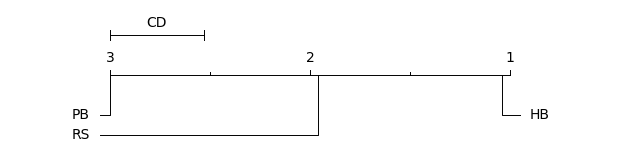

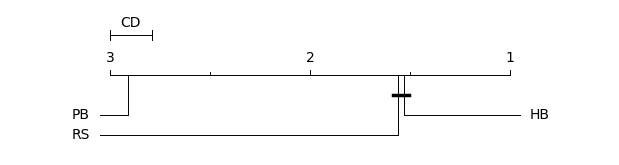

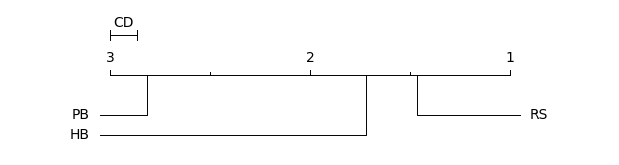

Prior bad


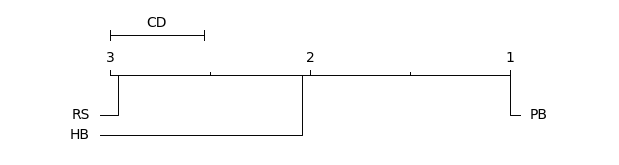

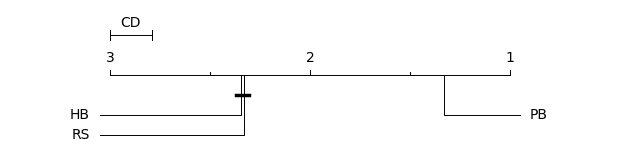

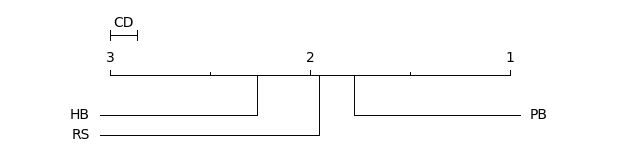

Prior good+bad


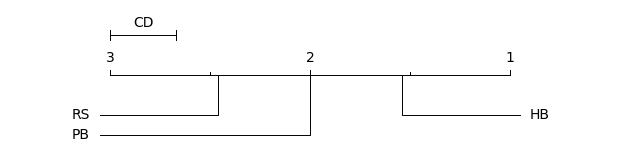

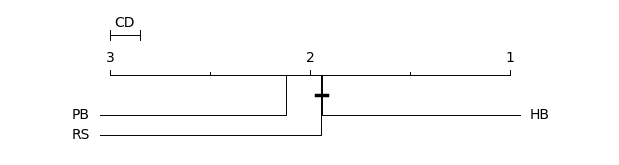

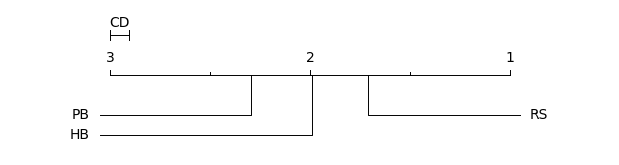

In [9]:
cumulative_data={}
for p_n,prior in enumerate(fig5["priors"]):
    cumulative_data[prior]={}
    for max_f in fig5["max_f"]:
        cumulative_data[prior][max_f]=pd.DataFrame()
        for fidelity in [item for item in fig5["f_space"] if fig5["min_f"] <= item <= max_f]:
            cumulative_data[prior][max_f]=pd.concat([cumulative_data[prior][max_f],fig5["singular"][prior][fidelity]],ignore_index=True)

fig5["dataset"]=cumulative_data

resultframes={}
for p_n,prior in enumerate(fig5["priors"]):
    print(f"Prior {prior}")
    resultframes[prior]={}
    for max_f in fig5["max_f"]:
        resultframes[prior][max_f]=autorank(fig5["dataset"][prior][max_f])
        plot_stats(resultframes[prior][max_f],allow_insignificant=True)
        plt.show()